## Autoencoders
Implements a very basic autoencoder following the KiKaBen tutorial: https://kikaben.com/how-to-reduce-image-noises-by-autoencoder/

## Download the MNIST data

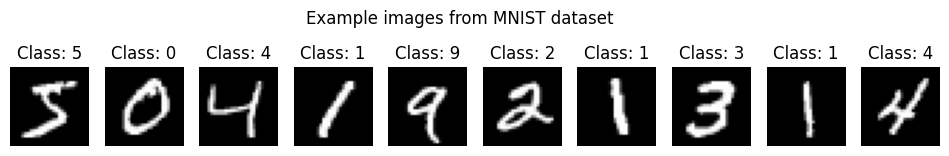

In [8]:
import torch
import numpy as np
import tlc
from torchvision.transforms import v2
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.v2.functional as F

transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),])
# Load MNIST dataset
X_train = datasets.MNIST('./data', train=True, download=True)
X_test = datasets.MNIST('./data', train=False, download=True)

# Visualize some samples
plt.figure(figsize=(12, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    input, classes = X_train[i]
    plt.imshow(input, cmap="gray")
    plt.title(f"Class: {classes}")
    plt.axis("off")

plt.suptitle("Example images from MNIST dataset")
plt.show()

In [9]:
X_train.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## Define very basic autoencoder architecture

In [3]:
# Define the Autoencoder model
class Autoencoder(nn.Module):

    def __init__(self, device="cpu"):
        super(Autoencoder, self).__init__()
        self.device = device
        
        self.enc_fc = nn.Linear(28 * 28, 64)
        self.enc_act = nn.ReLU()

        self.dec_fc = nn.Linear(64, 28 * 28)
        self.dec_act = nn.Sigmoid()

    def encode(self, x):
        x = self.enc_fc(x)
        x = self.enc_act(x)
        return x
    
    def decode(self, x):
        x = self.dec_fc(x)
        x = self.dec_act(x)
        return x

    def forward(self, x):
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded


## Define loss, optimicer and data

In [4]:

# Initialize the model and move to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder(device).to(device)

# Define optimizer and loss function
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Data splitting
train_size = int(0.99 * len(X_train))
valid_size = len(X_train) - train_size
X_train, X_valid = torch.utils.data.random_split(X_train, [train_size, valid_size])

# Define the collate function
def collate_fn(batch):
    images, _ = zip(*batch)
    img = np.array([np.asarray(image) for image in images]) / 255.0
    img = torch.tensor(img.reshape(-1, 28*28), dtype=torch.float32)
    return img.to(device)

# DataLoader creation
batch_size = 128
train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)
valid_loader = torch.utils.data.DataLoader(X_valid, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)


## Define train and validation functions

In [5]:


# Training function
def train(model, train_loader):
    model.train()
    running_loss = 0.0
    for input in tqdm(train_loader):

        decoded = model(input)
        loss = loss_fn(decoded, input)

        # Zero grad and backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_loader)
    return running_loss

# Validation function
def valid(model, valid_loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for input in tqdm(valid_loader):
            decoded = model(input)
            running_loss += loss_fn(decoded, input).item()

    running_loss /= len(valid_loader)  # average loss of this epoch
    return running_loss



In [ ]:
structure = (tlc.PILImage("Image"), tlc.CategoricalLabel("Label", classes=X_train.classes))
train_table = tlc.Table.from_torch_dataset(dataset = X_train, structure=structure, table_name="original", dataset_name="train", project_name="tld test")

In [6]:
# Training loop
max_epoch = 3
for epoch in range(max_epoch):
    train_loss = train(model, train_loader)
    valid_loss = valid(model, valid_loader)
    print(f"Epoch {epoch + 1}/{max_epoch}, Loss train: {train_loss:.4f}, valid: {valid_loss:.4f}")


  0%|          | 0/465 [00:11<?, ?it/s]


KeyboardInterrupt: 

## Test the model

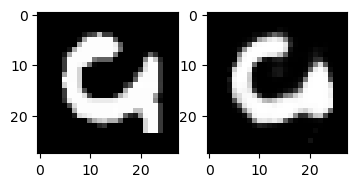

In [181]:
# Select a random sample
sample = next(iter(test_loader))
# Use the encode and decode functions
encoded = model.encode(sample)
decoded_img = model.decode(encoded).detach().numpy()

# Plot the images
plt.figure(figsize=(4, 3))
plt.subplot(1,2,1)
plt.imshow(sample.reshape(28, 28), cmap="gray")

plt.subplot(1,2,2)
plt.imshow(decoded_img.reshape(28, 28), cmap="gray")
plt.show()